In [129]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress all warnings
warnings.filterwarnings("ignore")

In [130]:
# Configure load path
import pickle
import pandas as pd
import os
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score, d2_absolute_error_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import xgboost as xgb
from dateutil.relativedelta import relativedelta
from tqdm import tqdm, tqdm_notebook
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.tree    import DecisionTreeRegressor
from sklearn.tree    import DecisionTreeClassifier
import itertools

os.chdir("C:/Users/Win11/Documents/Repos/Acorn-Casino-PLTV/")

bs_token = 'S7Fek4qridIxY1sUfYUyOl0rLak1Eedeg0TTCWHzUHqIFuUGN07xZtd41ZCp2UvE'  # Token Bingo Arena
host = 'td.winnerstudio.vip'

# Path Thinking Engine tables
tables_path = 'pltv_lucky_accorn_ios_tables.py'
start_date = (datetime.now() - timedelta(days = 65)).strftime('%Y-%m-%d')
end_date = (datetime.now() - timedelta(days = 29)).strftime('%Y-%m-%d')
client_name = 'ios'

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')

In [131]:
with open('acorn_ios_ptlv_dictionary_2024_jan.pkl', 'rb') as file:
    model_dict = pickle.load(file)
model_dict.head()

,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['p7_diff', 'p6_diff', 'p5_diff', 'p4_di..."


## 1. Load the data and incorporate the predictions 

This should be everything that you can get from the previous step, except the API data 

In [132]:
def load_data(tables, bs_token, host):
    def pull_data(sql_script, bs_token, host):

        data = {
            'token':          bs_token,
            'format':         'json_object',
            'timeoutSeconds': 2000,
            'sql':            sql_script
        }

        data = str(urlencode(data))
        response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

        # Sample list of JSON strings
        json_list = response.text.split('\n')[1:]

        # Convert JSON strings to dictionaries
        dict_list = []
        for json_str in json_list:
            try:
                dict_list.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON: {e}")

        # Create a pandas DataFrame
        data = pd.DataFrame(dict_list).sort_index(axis = 1)
        print(data)
        # Display the DataFrame
        return data

    # Load the first data using USER_PAYMENT, and then iteatevely join the remaining data for trainning

    df = pull_data(tables[0], bs_token, host)
    for i in range(1, len(tables)):
        new_data = pull_data(tables[i], bs_token, host)
        df = df.merge(new_data, on = '#account_id', how = 'left')

    return df

# Load queries from remote python script (This needs to be perfect).  Overall, you might want to have the lsit here
exec(open(tables_path).read())
tables = locals().get('tables')
training_columns = locals().get('training_columns')
training_columns_feb = locals().get('training_columns_feb')

# Create df by loading information and joining on account_id
df = load_data(tables, bs_token, host)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
       #account_id  cp1  cp3  cp7     p1     p10    p100    p105     p11  \
0         10044296    1    1    6  4.435  50.035  54.470  54.470  50.035   
1         10044333    0    0    0  0.000   0.000   0.000   0.000   0.000   
2         10045415    0    0    0  0.000   0.000   0.000   0.000   0.000   
3         10045701    0    0    2  0.000   3.248   6.748   6.748   3.248   
4         10046284    0    0    0  0.000   0.000   0.000   0.000   0.000   
...            ...  ...  ...  ...    ...     ...     ...     ...     ...   
155746    10197857    0    0    0  0.000   0.000   0.000   0.000   0.000   
155747    10198003    0    0    0  0.000   0.000   0.000   0.000   0.000   
155748    10198285    0    0    0  0.000   0.000   0.000   0.000   0.000   
155749    10198440    0    0    0  0.000   0.000   0.000   0.000   0.000   
155750    10198527    0    0    0  0.000   0.000   0.000   0.000   0.000   

          p112  ...     p

In [133]:
# Data preprocessing and transformations
df['#account_id'] = df['#account_id'].astype(str)
df['register_time'] = pd.to_datetime(df['register_time'], errors = 'coerce')
df['date'] = df['register_time'].dt.strftime('%Y%m%d').astype(float)  # Change to float if needed

df = df.fillna(0)

In [134]:
# Calculate differences
day_columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7']
for i in range(len(day_columns) - 1, 0, -1):
    df[f'{day_columns[i]}_diff'] = df[day_columns[i]] - df[day_columns[i - 1]]

In [135]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]
def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:
        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}'] + data[f'ad{response}']

        for reg in predictors_days:

            if int(response) > int(reg):
                
                data[f'p_last_diff_7_{reg}'] = data[f'p{reg}'] - data[f'p7']
                data[f'w_last_diff_7_{reg}'] = data[f'w{reg}'] - data[f'w7']
                columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)][['Columns']].reset_index(drop=True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
                
                # Load the model
                model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)]['Model'].reset_index(drop=True).values[0]

                # Make the prediction (Make sure is done only for those on which makese sense)
                prediction = model.predict(data[columns])
                data[f'pred_{reg}_{response}'] = prediction + data[f'p{reg}']- data[f'w{reg}'] + data[f'ad{reg}']
                del data[f'p_last_diff_7_{reg}']
                del data[f'w_last_diff_7_{reg}']

    return data

df = add_predictions(df, model_dict, response_days_input, predictors_days_input)

## 2. Add media source 

Add the media source

In [60]:
api_details = {'bundle_id': 'com.acorncasino.slots', 'start': start_date, 'end':  end_date}
api_url = 'http://acorncasino-ios.twilightgift.club/server/media_source_cost'

# Send a GET request to the API
response = requests.post(api_url, api_details)
if response.status_code == 200:
    # Request was successful
    api_df = response.json()  # Parse the JSON response if the API returns JSON data
    api_df = pd.DataFrame(api_df['data'])
    api_df['api_installs'] = api_df['user_ids'].apply(lambda x: len([int(item.strip()) for item in x.split(",") if item.strip()]))
    print('Loaded', api_df.shape)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


Loaded (186, 7)


In [61]:
api_df

,date,media_source,cost,revenue_d7,withdraw_d7,user_ids,api_installs
0,20231228,applovin_int,13837.32,22647.39,18107.07,"10175402,10175413,10175420,10175418,10175421,1...",1137
1,20231228,moloco_int,8471.50,13099.22,6852.62,"10175403,10175407,10175416,10175425,10175439,1...",1047
2,20231228,FB_web,36884.39,22673.34,18664.39,"10175405,10175411,10175408,10175410,10175412,1...",1872
3,20231228,unityads_int,989.09,471.33,345.00,"10175406,10175507,10175513,10175617,10175624,1...",150
4,20231228,vungle_int,1229.49,61.03,39.90,"10175430,10175636,10175732,10176070,10176143,1...",94
...,...,...,...,...,...,...,...
181,20231123,FB_web,4585.20,2189.89,1504.41,"10040835,10084126,10048091,10040851,10040853,1...",295
182,20231123,applovin_int,2702.70,2321.14,846.69,"10040895,10040925,10040930,10041076,10041168,1...",284
183,20231122,moloco_int,2934.24,2104.73,1851.85,"10039497,10039498,10039501,10039504,10039506,1...",528
184,20231122,FB_web,3957.64,4239.07,1992.96,"10039499,10039503,10039508,10039509,10039512,1...",323


In [62]:
api_df = api_df.groupby('date')[['cost', 'revenue_d7', 'withdraw_d7', 'api_installs']].sum().reset_index(drop = False).sort_values(by = 'date')
api_df.head()

,date,cost,revenue_d7,withdraw_d7,api_installs
0,20231122,9057.12,8672.69,5648.90,1056
1,20231123,10238.10,6325.87,4663.57,1106
2,20231124,11521.74,14968.13,10929.83,1245
3,20231125,11905.94,8963.85,3919.00,1298
4,20231126,10862.30,10654.07,9428.93,1368


In [63]:
n_values = df.columns[df.columns.str.match(r'pred_\d+_\d+')].str.extract(r'pred_\d+_(\d+)').dropna()[0].unique() # These are the responses, after removing the availables.
available_k_values = [int(col.split('_')[1]) for col in df.columns if col.startswith('pred_')] # What are the numbers after 'pred_'
pred_list = ['pred_14', 'pred_28', 'pred_56', 'pred_63', 'pred_70', 'pred_77', 'pred_84', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112', 'pred_119', 'pred_126', 'pred_133']

df['te_installs'] = 1
agg_df = df.fillna(0).groupby('date')[[col for col in df.columns if col.startswith("p") or col.startswith("w") or col.startswith("ad") or col.startswith("act") or col.startswith("actual_")] + ['te_installs']].sum().reset_index()
agg_df = api_df[['date', 'api_installs', 'cost', 'revenue_d7', 'withdraw_d7']].merge(agg_df, on = 'date', how = 'inner')

agg_df['payment_increase']    = (agg_df['revenue_d7'] - agg_df['p7']) / agg_df['p7']
agg_df['rpi_increase']        = ((agg_df['revenue_d7'] / agg_df['api_installs'].astype(float)) - (agg_df['p7'] / agg_df['te_installs']) / (agg_df['p7'] / agg_df['te_installs']))
agg_df['installs_difference'] = (agg_df['api_installs'] - agg_df['te_installs']) / agg_df['te_installs'] # ['Install', 'installs']'Install' is API
agg_df['withdrawn_ratio']     = agg_df['withdraw_d7'] / agg_df['revenue_d7']
agg_df['return_p_d7']         = agg_df['p7'] / agg_df['cost'] 
agg_df['return_ad_d7']        = agg_df['ad7'] / agg_df['cost'] 
today = pd.to_datetime((datetime.now() - timedelta(days = 1)).strftime('%Y-%m-%d'))


In [12]:
# Generate pred roas cols by dividing pred_revenue by spending (Name does not change)
agg_df[[col for col in df.columns if col.startswith("pred_")]] = agg_df[[col for col in df.columns if col.startswith("pred_")]].div(agg_df['cost'], axis = 0)

In [101]:
agg_df_train = agg_df[['date'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] + ['rpi_increase'] + ['installs_difference'] + ['withdrawn_ratio'] 
                        + [col for col in agg_df.columns if col.startswith("pred_")] + [col for col in agg_df.columns if col.startswith("w")] + [col for col in agg_df.columns if col.startswith("ad")]]

agg_df_train.sample(10)

,date,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,pred_7_14,pred_8_14,...,ad6,ad63,ad7,ad70,ad77,ad8,ad84,ad9,ad91,ad98
7,20231129,15308.02,13385.63,8379.39,-0.106647,6.306567,-0.205206,0.625999,7478.303192,7734.058993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,20231219,53784.51,60072.01,35709.23,-0.164743,12.417916,-0.192023,0.594440,40307.606401,42216.251575,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,20231203,18166.54,11883.85,7529.60,-0.108259,4.883094,-0.212783,0.633599,5836.135840,6916.163774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,20231127,10936.95,10395.47,5285.58,-0.029832,6.917342,-0.208559,0.508450,5656.862862,6089.134418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20231125,11905.94,8963.85,3919.00,-0.040412,5.905894,-0.208054,0.437201,5594.906394,5353.301493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,20231214,53020.23,29471.48,12752.80,-0.113603,5.978802,-0.207544,0.432717,23915.914232,27158.263073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,20231223,59061.96,78702.36,67696.19,-0.183431,20.433105,-0.206569,0.860155,41870.282613,46212.228026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,20231206,26021.99,14434.37,5826.37,-0.038602,4.766828,-0.221462,0.403646,7657.458287,8073.779728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,20231128,12087.80,17641.92,8684.99,-0.054328,10.792727,-0.215933,0.492293,7402.592296,7764.724600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,20231215,57079.90,37240.37,12764.53,-0.180179,7.374268,-0.188652,0.342761,35363.161822,33761.239079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check numbers are pulled decently well


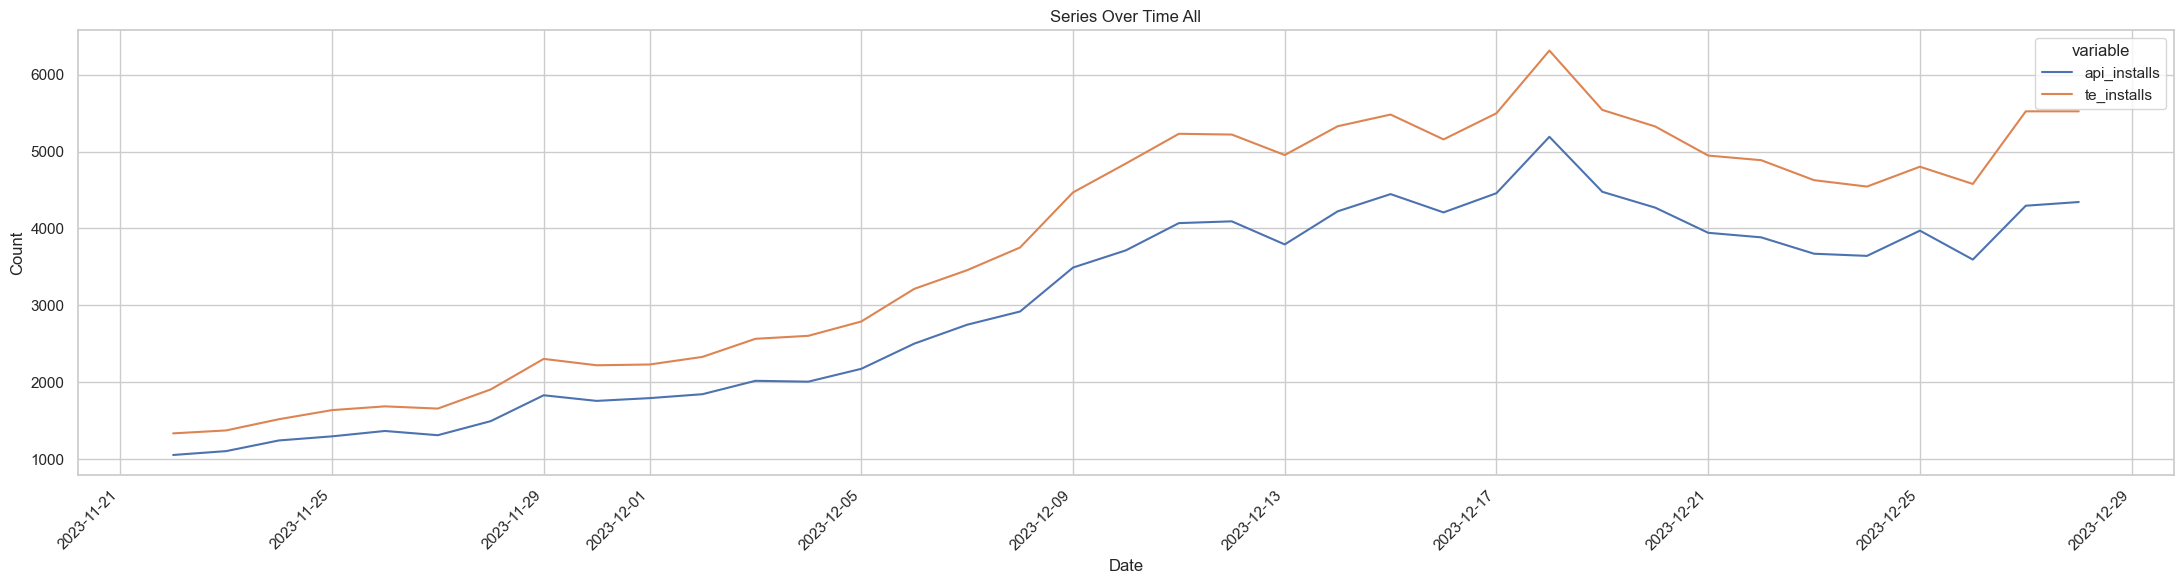

In [65]:

# Set the seaborn style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['api_installs', 'te_installs'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time All')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

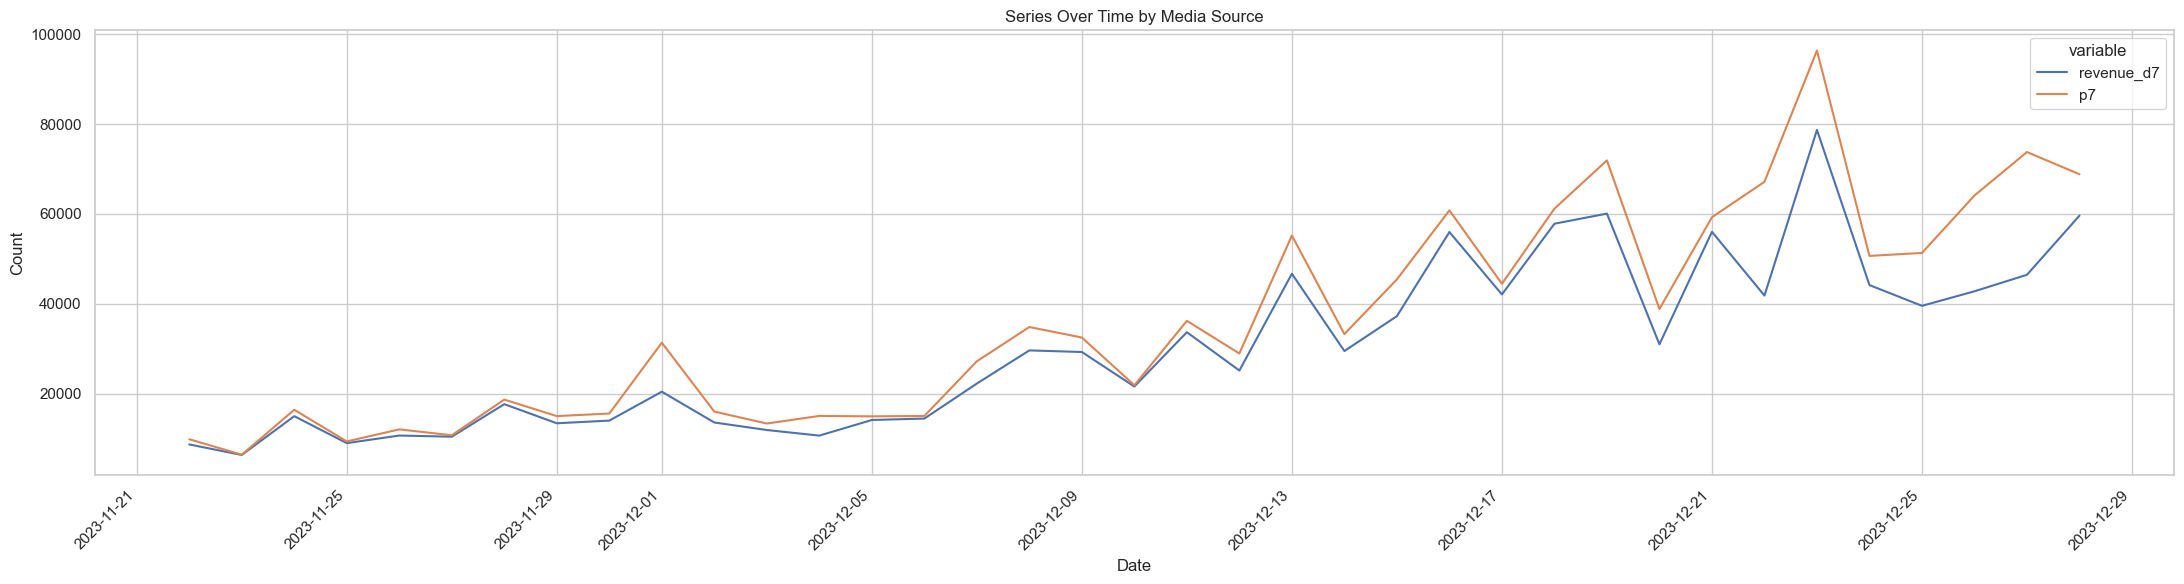

In [66]:
# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['revenue_d7', 'p7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

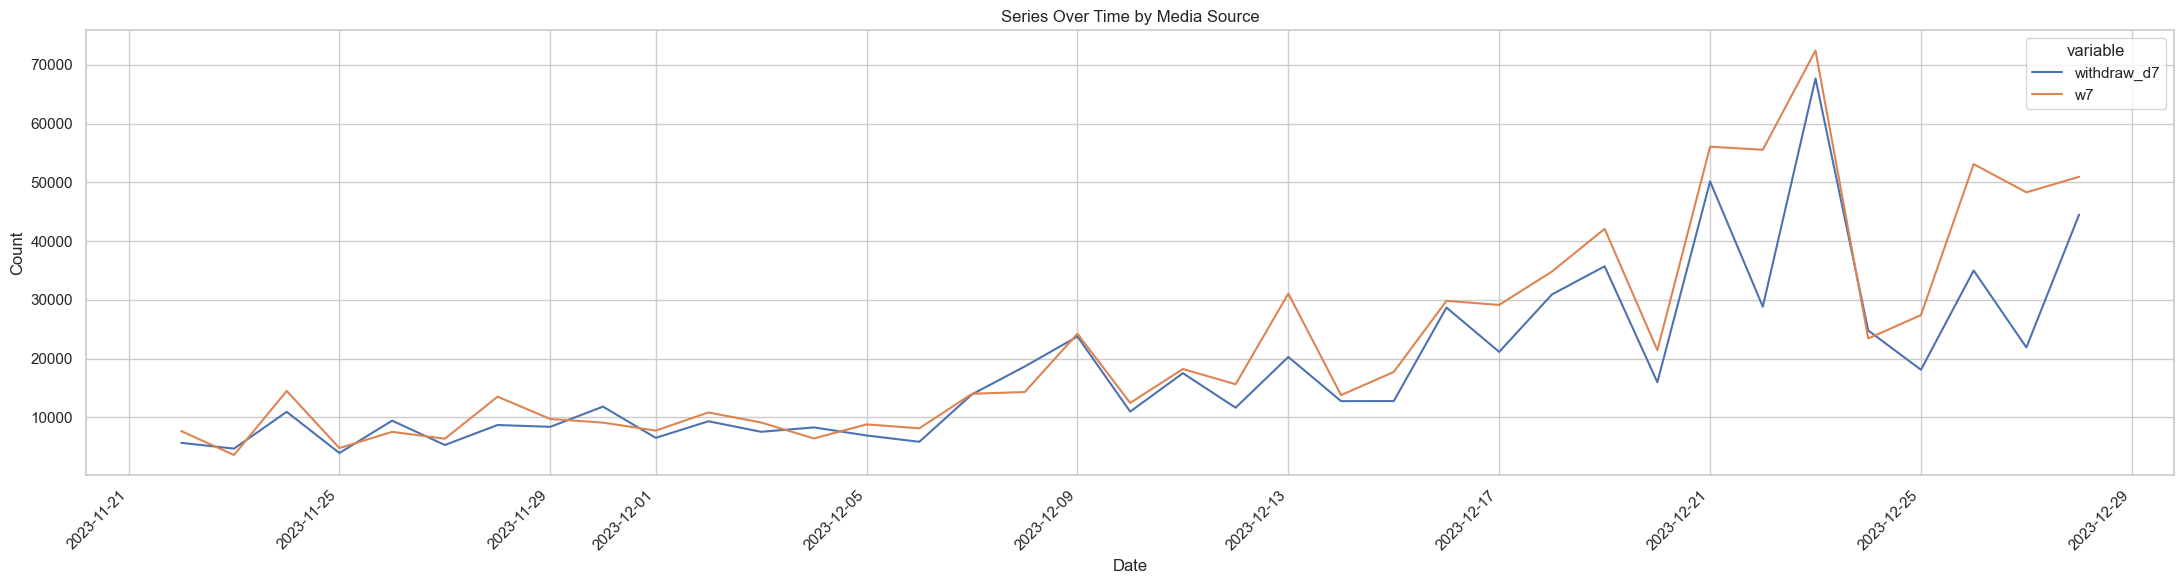

In [67]:
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(agg_df, id_vars=['date'], value_vars=['withdraw_d7', 'w7'])
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Series Over Time by Media Source')

# Display the legend
# plt.legend(title='Media Source')

# Set x-axis ticks at specific intervals
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Show the plot
plt.tight_layout()  # Optional for better layout
plt.show()

## 3. Incorporate the responses from the BI tool 

In [68]:
file_path = (os.getcwd()).replace('\\', '/') + r'/roi_all_by_user_20240126191117.xlsx'.replace('\\', '/')
bi_tool_actuals = pd.read_excel(file_path)

bi_tool_actuals = bi_tool_actuals[bi_tool_actuals['date'] != '--']

In [69]:
bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
201,20230701,"5,434.91（26.98%）","6,812.31（33.82%）","8,463.36（42.02%）"
200,20230702,"6,285.81（32.1%）","7,729.50（39.47%）","9,391.31（47.96%）"
199,20230703,"6,571.92（32.45%）","8,410.40（41.53%）","11,210.71（55.36%）"
198,20230704,"6,919.64（35.8%）","8,616.98（44.59%）","11,055.64（57.2%）"
197,20230705,"5,869.21（35.32%）","7,294.75（43.9%）","8,419.84（50.67%）"
196,20230706,"5,429.40（35.01%）","7,254.33（46.77%）","9,238.93（59.57%）"
195,20230707,"5,111.15（36.23%）","6,314.18（44.76%）","7,951.88（56.37%）"
194,20230708,"4,443.10（33.02%）","5,826.80（43.3%）","7,444.19（55.32%）"
193,20230709,"7,599.36（57.2%）","9,683.39（72.89%）","11,869.33（89.35%）"
192,20230710,"5,924.59（43.15%）","7,611.38（55.43%）","9,553.12（69.57%）"


In [70]:
# Convert percentage strings to floats
def convert_percentage_string_to_float(percentage_string):
    try:
        return float(percentage_string.split(' ')[1][1:-2]) / 100
    except (ValueError, IndexError):
        return float(percentage_string.split('（')[1][0:-2]) / 100

bi_columns = ['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)','90-day recovery (rate)', '120-day recovery (rate)']
for col in bi_columns:
    bi_tool_actuals[col] = bi_tool_actuals[col].apply(convert_percentage_string_to_float)

bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
201,20230701,0.2698,0.3382,0.4202
200,20230702,0.3210,0.3947,0.4796
199,20230703,0.3245,0.4153,0.5536
198,20230704,0.3580,0.4459,0.5720
197,20230705,0.3532,0.4390,0.5067
196,20230706,0.3501,0.4677,0.5957
195,20230707,0.3623,0.4476,0.5637
194,20230708,0.3302,0.4330,0.5532
193,20230709,0.5720,0.7289,0.8935
192,20230710,0.4315,0.5543,0.6957


In [71]:
bi_tool_actuals['date'].max()
# bi_tool_actuals['date'].dtype

20240118

In [72]:
# MERGE BI TOOL TO MY DATA (AGG DF INCLUDES BI DATA)

bi_tool_wanted_cols = ['date', 'Recovery on the 28th (rate)']

# agg_df['channel'] = agg_df['media_source']
# bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
agg_df = pd.merge(agg_df, bi_tool_actuals[bi_tool_wanted_cols], on = 'date')
agg_df.sample(10)


,date,api_installs,cost,revenue_d7,withdraw_d7,p1,p10,p100,p105,p11,...,pred_28_133,pred_35_133,te_installs,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,return_p_d7,return_ad_d7,Recovery on the 28th (rate)
18,20231210,3716,41000.42,21567.61,10966.57,10679.48383,26995.42119,144733.41014,144733.41014,28924.27119,...,108143.850905,98972.110029,4845,-0.013003,4.803985,-0.233024,0.508474,0.532964,0.0,0.6306
5,20231127,1313,10936.95,10395.47,5285.58,4043.63036,12527.82930,42857.66382,42857.66382,13302.87130,...,20588.907522,24055.807014,1659,-0.029832,6.917342,-0.208559,0.508450,0.979718,0.0,0.4672
8,20231130,1759,14595.90,13981.43,11817.97,5656.99773,20398.97851,82720.11033,82720.11033,21299.89914,...,48875.727543,52660.497669,2222,-0.101181,6.948511,-0.208371,0.845262,1.065733,0.0,0.7316
9,20231201,1795,16334.34,20415.13,6499.97,16475.38636,38835.38873,125815.33251,125815.33251,40798.01573,...,106492.498397,111222.180497,2232,-0.348275,10.373331,-0.195789,0.318390,1.917725,0.0,0.7835
33,20231225,3972,63913.80,39535.69,18089.01,17487.89519,60638.07373,139177.73647,139177.73647,64602.02673,...,112613.247404,114935.356753,4803,-0.229558,8.953598,-0.173017,0.457536,0.802888,0.0,0.4724
13,20231205,2176,20987.00,14117.10,6905.50,7708.67378,18070.40762,140183.47102,140183.47102,19590.43709,...,70705.869354,106205.508582,2791,-0.054096,5.487638,-0.220351,0.489159,0.711128,0.0,0.5552
11,20231203,2020,18166.54,11883.85,7529.60,5011.61584,17673.11789,62217.86225,62217.86225,19335.06889,...,51829.041094,39233.739483,2566,-0.108259,4.883094,-0.212783,0.633599,0.733578,0.0,0.8929
4,20231126,1368,10862.30,10654.07,9428.93,3227.22573,16902.27172,97786.72830,97786.72830,18761.90130,...,57211.587116,49399.423690,1688,-0.114049,6.788063,-0.189573,0.885007,1.107092,0.0,0.5742
36,20231228,4344,61411.79,59623.70,44515.84,21166.29835,94357.51468,219402.98121,219402.98121,109766.66131,...,236052.821776,169200.228338,5523,-0.133804,12.725529,-0.213471,0.746613,1.120860,0.0,0.6754
25,20231217,4459,55968.07,42076.22,21138.65,19800.53206,55335.78403,166025.44574,166025.44574,61478.14855,...,139997.424880,149953.873621,5498,-0.053676,8.436246,-0.188978,0.502389,0.794432,0.0,0.6733


### Day 7 to 14 and

### Day 28 to day 100 growth (Pull the data from the BI tool)

In [73]:
bi_tool_actuals

for col in []:
    bi_tool_actuals[col] = bi_tool_actuals[col].apply(convert_percentage_string_to_float)

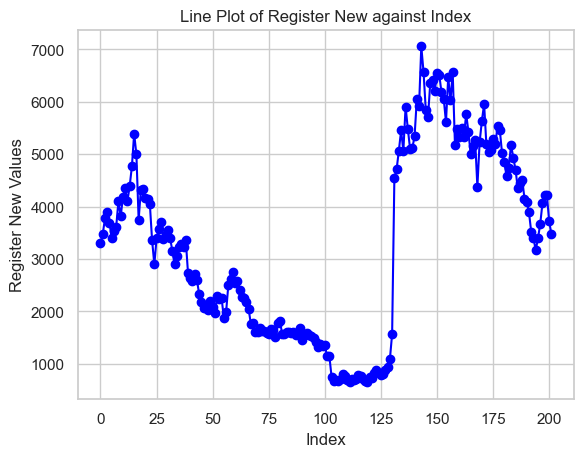

In [74]:

bi_tool_actuals['Register new'].plot(kind='line', marker='o', linestyle='-', color='blue')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Register New Values')
plt.title('Line Plot of Register New against Index')

# Display the plot
plt.show()

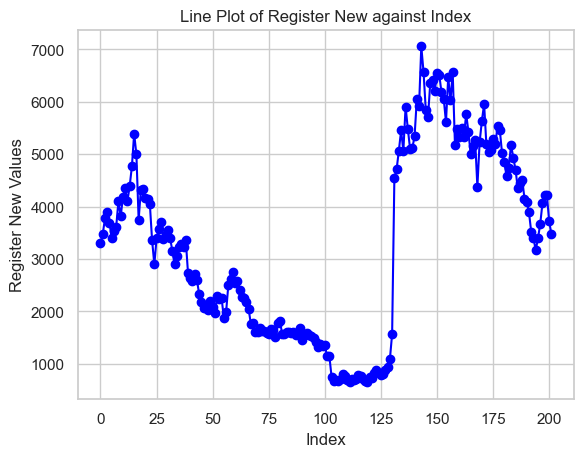

In [75]:
bi_tool_actuals['Register new'].plot(kind='line', marker='o', linestyle='-', color='blue')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Register New Values')
plt.title('Line Plot of Register New against Index')

# Display the plot
plt.show()

In [76]:
columns = ['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)','90-day recovery (rate)', '120-day recovery (rate)']
used_num_bi = bi_tool_actuals[(bi_tool_actuals['date'] > 20231010) & (bi_tool_actuals['date'] <= 20231025)].groupby('date')[columns].sum().reset_index()
used_num_bi['date'] = pd.to_datetime(used_num_bi['date'].astype(str), format='%Y%m%d').dt.strftime('%Y%m%d')


denom = used_num_bi['7-day recovery (rate)'].values
for col in columns:
    print(col)
    used_num_bi[col] = used_num_bi[col] / denom

daily_growth = used_num_bi.mean().reset_index()
daily_growth

7-day recovery (rate)
14-day recycling (rate)
Recovery on the 28th (rate)
90-day recovery (rate)
120-day recovery (rate)


,index,0
0,date,1348734080154008179702400722555897417740479093...
1,7-day recovery (rate),1.0
2,14-day recycling (rate),1.221852
3,Recovery on the 28th (rate),1.47318
4,90-day recovery (rate),1.847519
5,120-day recovery (rate),1.874508


In [77]:
mult_14 = daily_growth[daily_growth['index'] == '14-day recycling (rate)'][0].values[0]
mult_28 = daily_growth[daily_growth['index'] == 'Recovery on the 28th (rate)'][0].values[0]
linear_growth_rate = (daily_growth[daily_growth['index'] == '90-day recovery (rate)'][0].values[0] - mult_28) / (90 - 35)

print(mult_14, mult_28, linear_growth_rate)

1.2218518277171337 1.473180489144073 0.006806150959772336


### Check the Joint results

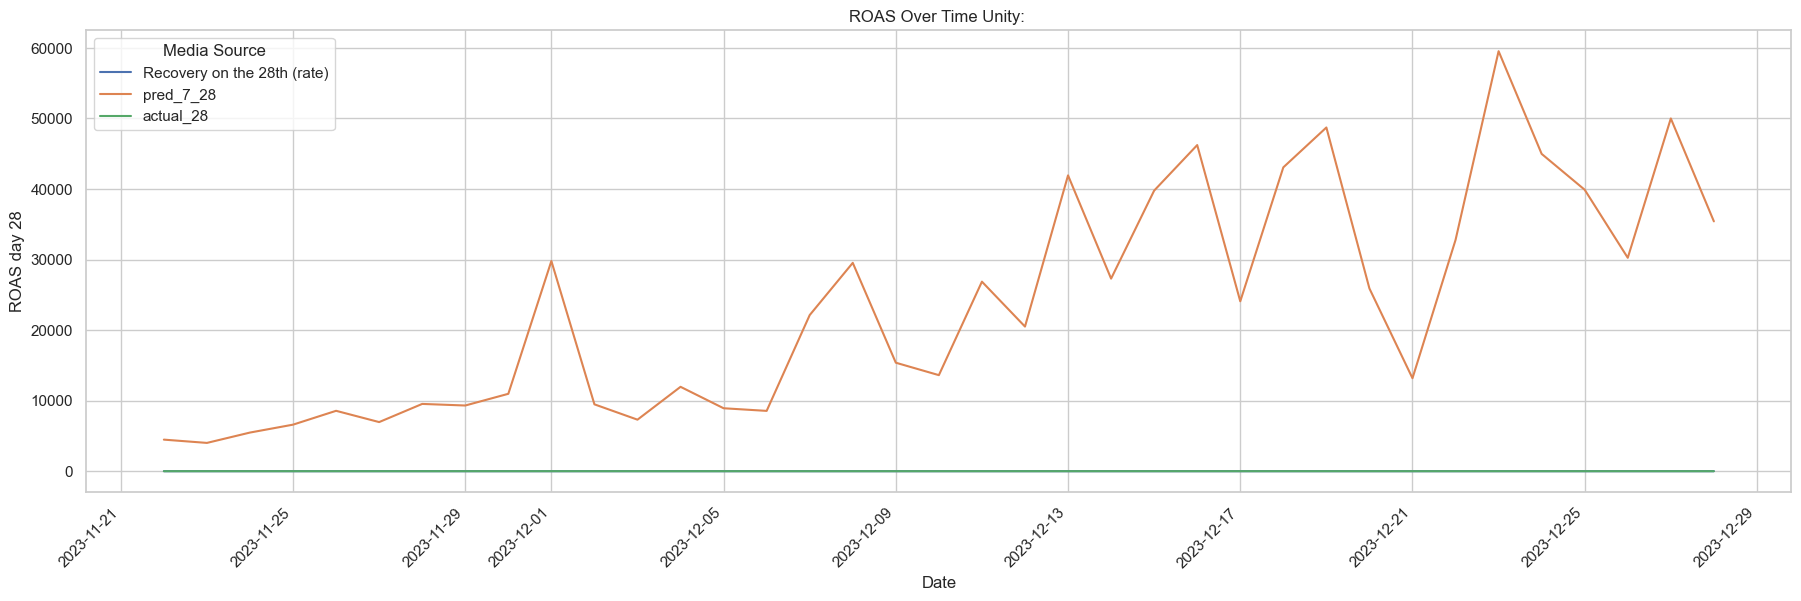

In [78]:
filtered_df = agg_df.copy()#[agg_df['channel'] == sourcesito]
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by='date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date'], value_vars=['Recovery on the 28th (rate)', 'pred_7_28', 'actual_28'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ')

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

## Find the best configuration to train correction rule

In [79]:
bias = 0.15 



In [102]:
w_col_names = [col for col in agg_df.columns if re.match(r'^w\d*$', col) is not None]
p_col_names = [col for col in agg_df.columns if re.match(r'^p\d*$', col) is not None]
agg_df_train = agg_df[agg_df['api_installs'] > 50][['date'] + ['te_installs'] + ['cost'] + ['revenue_d7'] + ['withdraw_d7'] + ['payment_increase'] 
                        + ['rpi_increase'] + ['installs_difference'] + ['withdrawn_ratio'] + ['Recovery on the 28th (rate)']
                         + [col for col in agg_df.columns if col.startswith("ad") ]
                        + [col for col in agg_df.columns if col.startswith("pred_") ] + w_col_names + p_col_names]

agg_df_train['d7_28_increase_api'] = agg_df_train['Recovery on the 28th (rate)'] - agg_df_train['revenue_d7']/agg_df_train['cost']
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])
agg_df_train['d7_28_increase_pred'] = agg_df_train['pred_7_28'] - (agg_df_train['p7']/agg_df_train['cost'] - agg_df_train['withdraw_d7']/agg_df_train['cost'])


In [103]:
# GET THE COLUMN GROUPS
validation_sets = 3
agg_df_train['validation_set_id'] = pd.qcut(agg_df_train['date'].astype(float).values, validation_sets)

In [104]:
agg_df_train.groupby('validation_set_id').size()

validation_set_id
(20231121.999, 20231204.0]    13
(20231204.0, 20231216.0]      12
(20231216.0, 20231228.0]      12
dtype: int64

In [105]:
# Check for nulls, infinities and select the model_cols
model_cols = agg_df_train[agg_df_train.columns[5:]].columns
model_cols
null_rows = agg_df_train[agg_df_train['payment_increase'].isnull()]
print(null_rows)
infinity_rows = agg_df_train[np.isinf(agg_df_train['payment_increase'])]
infinity_rows

Empty DataFrame
Columns: [date, te_installs, cost, revenue_d7, withdraw_d7, payment_increase, rpi_increase, installs_difference, withdrawn_ratio, Recovery on the 28th (rate), ad1, ad10, ad100, ad105, ad11, ad112, ad119, ad12, ad126, ad13, ad133, ad14, ad15, ad16, ad17, ad18, ad19, ad2, ad20, ad21, ad22, ad23, ad24, ad25, ad26, ad27, ad28, ad3, ad35, ad4, ad42, ad49, ad5, ad56, ad6, ad63, ad7, ad70, ad77, ad8, ad84, ad9, ad91, ad98, pred_7_14, pred_8_14, pred_9_14, pred_10_14, pred_11_14, pred_12_14, pred_13_14, pred_7_28, pred_8_28, pred_9_28, pred_10_28, pred_11_28, pred_12_28, pred_13_28, pred_14_28, pred_15_28, pred_16_28, pred_17_28, pred_18_28, pred_19_28, pred_20_28, pred_21_28, pred_22_28, pred_23_28, pred_24_28, pred_25_28, pred_26_28, pred_27_28, pred_7_56, pred_8_56, pred_9_56, pred_10_56, pred_11_56, pred_12_56, pred_13_56, pred_14_56, pred_15_56, pred_16_56, pred_17_56, pred_18_56, pred_19_56, pred_20_56, pred_21_56, pred_22_56, pred_23_56, pred_24_56, ...]
Index: []

[0 ro

,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,Recovery on the 28th (rate),...,p70,p77,p8,p84,p9,p91,p98,d7_28_increase_api,d7_28_increase_pred,validation_set_id


### Modelling

In [106]:
# Define predictive model and the polynomial transformation (This should be kept for the dictionary with the exception of the dynamic column. In this case: d7_28_increase_pred)

## Addition
agg_df_train['return_withdraw_d7'] = agg_df_train['withdraw_d7'] / agg_df_train['cost'] 
agg_df_train['return_p_d7'] = agg_df_train['p7'] / agg_df_train['cost'] 

## Definintion in list 
model_cols = ['return_withdraw_d7', 'return_p_d7', 'payment_increase', 'rpi_increase', 'installs_difference', 'withdrawn_ratio', 'd7_28_increase_api', 'd7_28_increase_pred', 'te_installs']

## Algorithm 
def create_huber(alpha, epsi, cols, weights_train): 
    
    columns = cols
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), columns)
        ],
        remainder='passthrough'
    )


    # Create the pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HuberRegressor(fit_intercept = True, epsilon = epsi, alpha = alpha, warm_start = False, max_iter = 1000))
    ])

    pipe.named_steps['regressor'].sample_weight = weights_train

    return pipe

## Feat engineering
def all_feature_enginerring(data, pred_col):

    """
    This is better to create before and the just utilise it in whatever model
        - Notice what you're doing with withdrawal day 100 (I am not so interested in withdrawal but it is fine)
    """
    
    # Inclusion of interpolation 
    column_list = ['withdrawn_ratio', pred_col, 'installs_difference']
    column_combinations = list(itertools.combinations(column_list, 2))

    for pair in column_combinations:
        column1, column2 = pair
        new_column_name = f"{column1}_times_{column2}"
        data[new_column_name] = data[column1] * data[column2]  # Example: Multiply values of two columns

    return data


In [34]:
model_results = []
all_model_results = []
alphas = [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2] 
epsils = [1, 1.05, 1.1, 1.3, 1.5, 1.7, 2, 2.5, 3] 

# for train_index, test_index in splits:
for date_group in tqdm(agg_df_train['validation_set_id'].unique()):
    
    print(date_group)

    train_data =  agg_df_train[agg_df_train['validation_set_id'] != date_group][model_cols]
    test_data =  agg_df_train[agg_df_train['validation_set_id'] == date_group][model_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'd7_28_increase_api']), train_data[f'd7_28_increase_api'] 
    X_test, y_test = test_data.drop(columns = [f'd7_28_increase_api']), test_data[f'd7_28_increase_api']

    old_cols = X_train[[col for col in X_train.columns if col != 'te_installs']].copy().columns
    X_train = all_feature_enginerring(X_train, 'd7_28_increase_pred')
    X_test = all_feature_enginerring(X_test, 'd7_28_increase_pred')

    weights_train = np.log1p(X_train['te_installs'])

    for alpha in alphas: 
        for epsi in epsils: 
            for cols in [old_cols, X_train.columns]:
                
                # Full trainning and testing 
                model = create_huber(alpha, epsi, old_cols, weights_train)
                model.fit(X_train[[col for col in cols if col != 'te_installs']], y_train)
                predictions = model.predict(X_test[[col for col in X_train.columns if col != 'te_installs']])
                mae = mean_absolute_error(y_test, predictions)
                r2 = r2_score(y_test, predictions)

                # Save the model into dictionary (Response, day, mo...)
                model_result = pd.DataFrame({
                    'Iteration': [str(alpha) + ' - ' + str(epsi) + ' - ' + str(len([col for col in cols if col != 'te_installs']))]
                    , 'Test at': [date_group]
                    , 'Model': [model]
                    , 'mae': [mae]
                    , 'r2': [r2]
                    , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
                })

                model_results.append(model_result)
    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)
all_model_results.shape[0]


  0%|          | 0/3 [00:00<?, ?it/s]

(20231121.999, 20231204.0]


 33%|███▎      | 1/3 [00:02<00:05,  2.57s/it]

(20231204.0, 20231216.0]


 67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]

(20231216.0, 20231228.0]


100%|██████████| 3/3 [00:06<00:00,  2.08s/it]


864

In [107]:
all_model_results.sort_values(by = 'mae').head(5)

,Iteration,Test at,Model,mae,r2,rel_mae
594,0.005 - 1 - 7,"(20231204.0, 20231216.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.082137,0.780591,0.513890
306,0.005 - 1 - 7,"(20231204.0, 20231216.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.082137,0.780591,0.513890
576,0 - 1 - 7,"(20231204.0, 20231216.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.082303,0.780242,0.512909
288,0 - 1 - 7,"(20231204.0, 20231216.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.082303,0.780242,0.512909
360,0.05 - 1 - 7,"(20231204.0, 20231216.0]","(ColumnTransformer(remainder='passthrough',\n ...",0.082374,0.779892,0.512490


In [108]:
all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'mae', ascending = True).head(10)

,mae,r2,rel_mae
Iteration,,,
0 - 1 - 10,0.137036,0.626001,0.405777
0 - 1 - 7,0.140330,0.623126,0.390824
0.02 - 1 - 10,0.142506,0.608578,0.378235
0.05 - 1.05 - 10,0.143599,0.611223,0.370581
0.01 - 1 - 7,0.144272,0.574861,0.363252
0.05 - 1 - 7,0.144653,0.579849,0.366699
0.1 - 1 - 10,0.145851,0.583916,0.367339
0.2 - 1.7 - 7,0.146150,0.555806,0.357945
0.15 - 1.7 - 7,0.146327,0.554383,0.357291


In [111]:
model_value = all_model_results.loc[all_model_results['Iteration'] == '0.2 - 1 - 10', 'Model'].iloc[0]
reset_df_plus = all_feature_enginerring(agg_df_train, 'd7_28_increase_pred')
cols_to_append = [
    'roas_d7_times_installs_difference',
    'withdrawn_ratio_times_installs_difference',
    'withdrawn_ratio_times_pred_7_28',
    'roas_d7_times_pred_7_28',
    'roas_d7_times_withdrawn_ratio',
    'pred_7_28_times_installs_difference'
]
cols_to_append = [
    'withdrawn_ratio_times_d7_28_increase_pred',
    'withdrawn_ratio_times_installs_difference',
    'd7_28_increase_pred_times_installs_difference']

subnormal = [col for col in old_cols if col != 'Installs']
subnormal.extend(cols_to_append)

predictions = model_value.predict(reset_df_plus[subnormal])

In [112]:
import plotly.express as px

# Assuming reset_df is your DataFrame
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'ROAS D7': (agg_df_train['revenue_d7']/agg_df_train['cost']), 'installs': agg_df_train['te_installs']})

# Create a scatter plot with size and color based on 'installs' and 'channel'
fig = px.scatter(pdf, x='ROAS D7', y='y_test', title='Association Actuals vs ROAS day 7', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['ROAS D7', 'y_test'],
                 size='installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='ROAS D7'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

In [113]:
pdf = pd.DataFrame({'y_test': agg_df_train['d7_28_increase_api'].values, 'predictions': predictions, 'installs': agg_df_train['te_installs']})

fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test'],
                 size='installs',  # Set size proportional to 'installs'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

In [114]:
pdf = pd.DataFrame({'y_test': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + agg_df_train['d7_28_increase_api'].values), 'predictions': ((agg_df_train['revenue_d7'].values - agg_df_train['withdraw_d7'].values)/agg_df_train['cost'].values + predictions)})

fig = px.scatter(pdf, x='predictions', y='y_test', title='Association Actuals vs Predictions', trendline='ols',
                 labels={'predictions': 'X-axis Label', 'y_test': 'Y-axis Label'},
                 template='plotly_dark',
                 hover_data=['predictions', 'y_test']
                )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='Predicted'),
    yaxis=dict(title_text='Actual user revenue'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()

## Fit to dictionary based on availables

In [115]:
dev_df = agg_df_train.copy(deep = True)

columns_rule = ['revenue_d7','withdraw_d7','installs','payment_increase','rpi_increase','installs_difference','is_facebook','pred_roas','roas_d7','withdrawn_ratio']
columns_rule = ['revenue_d7','withdraw_d7','payment_increase','rpi_increase','installs_difference']

max_date = df['date'].max()
dev_df['days_since_install'] = (max_date - dev_df['date']) # Needed? Yes


In [116]:
amrgb = all_model_results.groupby('Iteration')[['mae', 'r2', 'rel_mae']].mean().sort_values(by = 'rel_mae', ascending = False).reset_index(drop = False)
iteration_value = amrgb['Iteration'].values[0] #'0.05 - 1.5 - 11'
a = float(iteration_value.split(' - ')[0])
e = float(iteration_value.split(' - ')[1])
print(a,e)

0.0 1.0


In [117]:
payback_predictive_system = []

from tqdm import tqdm, tqdm_notebook

for y_day in tqdm(['14', '28']):
  for x_day in predictors_days:
    if int(y_day) > int(x_day):
  
      train = dev_df.copy()
      train['y'] = train['Recovery on the 28th (rate)'] - (train[f'p{x_day}'] - train[f'w{x_day}'] + train[f'ad{x_day}'])/train['cost']
      y = train[train['days_since_install'] <= (int(y_day) - 1)]['y'] # This is the regressors-based of d7_28_increment
      del train['y']
  
      # Make the regressors
      selected_columns = columns_rule + [f'pred_{x_day}_{y_day}']
      
      # Define X 
      X = train[train['days_since_install'] <= (int(y_day) - 1)]
      weights_train = np.log1p(X['te_installs'])
  
      # Define observation importance 0.01 - 1.05 - 160 - 1 - 10
      model = create_huber(0.0, 1.05, selected_columns, weights_train)
      model.fit(X[[col for col in selected_columns if col != 'te_installs']], y)
  
      # Save the model into dictionary (Response, day, model)
      payback = pd.DataFrame({
              'Available day': [x_day]
              , 'Target day': [y_day]
              , 'Model': [model]
              , 'Columns': [X[[col for col in selected_columns if col != 'te_installs']].columns]
              })
  
      payback_predictive_system.append(payback)

rules_dict = pd.concat(payback_predictive_system, ignore_index = True)
rules_dict

100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


,Available day,Target day,Model,Columns
0,7,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
1,8,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
2,9,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
3,10,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
4,11,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
5,12,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
6,13,14,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
7,7,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
8,8,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."
9,9,28,"(ColumnTransformer(remainder='passthrough',\n ...","Index(['revenue_d7', 'withdraw_d7', 'payment_i..."


In [118]:
dev_df_check = dev_df.copy(deep = True)

In [119]:
# Add predictions
integers_list = list(range(7, 28))
incremented_numbers = [str(number) for number in range(28, 36, 7)]
predictors_days_input = predictors_days = [str(integer) for integer in integers_list] + incremented_numbers

# Available dates as target (I am considering adding more values, above and below, maybe up to two on each side)
response_days_input = response_days = ["14", "28", "56", "63", "70", "77", "84", "91", "98", "100", "105", "112", "119", "126", "133"]

def add_predictions(data, model_dict, response_days, predictors_days):

    for response in response_days:

        data[f'actual_{response}'] = data[f'p{response}'] - data[f'w{response}'] + data[f'ad{response}'] 

        for reg in predictors_days:

            if int(response) > int(reg):
                                
                columns = list((model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)][['Columns']].reset_index(drop = True).values[0])[0]) #+ [f'p_last_diff_7_{reg}'] + [f'w_last_diff_7_{reg}']
    
                # Load the model
                model = model_dict[(model_dict['Available day'] == reg) & (model_dict['Target day'] == response)]['Model'].reset_index(drop = True).values[0]
    
                # Make the prediction (Make sure is done only for those on which makese sense)
                prediction = model.predict(data[columns])
                data[f'pred_{reg}_{response}_agg'] = prediction + (data[f'p{reg}']- data[f'w{reg}'] + data[f'ad{reg}'])/data[f'cost']
                
    return data

dev_df_check = add_predictions(dev_df_check, rules_dict, ['28'], predictors_days_input)


In [120]:
dev_df_check.sample(6)

,date,te_installs,cost,revenue_d7,withdraw_d7,payment_increase,rpi_increase,installs_difference,withdrawn_ratio,Recovery on the 28th (rate),...,pred_18_28_agg,pred_19_28_agg,pred_20_28_agg,pred_21_28_agg,pred_22_28_agg,pred_23_28_agg,pred_24_28_agg,pred_25_28_agg,pred_26_28_agg,pred_27_28_agg
1,20231123,1375,10238.10,6325.87,4663.57,-0.009124,4.719593,-0.195636,0.737222,0.5545,...,0.651879,0.705342,0.768750,0.799918,0.878796,0.830609,0.965108,0.931447,0.903428,0.951287
8,20231130,2222,14595.90,13981.43,11817.97,-0.101181,6.948511,-0.208371,0.845262,0.7316,...,0.969868,0.792125,0.950919,0.961577,0.966235,0.962485,0.989117,1.025184,1.006305,0.956075
3,20231125,1639,11905.94,8963.85,3919.00,-0.040412,5.905894,-0.208054,0.437201,0.5569,...,0.637849,0.678381,0.718675,0.690855,0.752437,0.679612,0.784724,0.678082,0.699318,0.728835
21,20231213,4955,44256.74,46682.23,20273.24,-0.154104,11.307469,-0.234511,0.434282,0.7114,...,0.703495,0.711397,0.711400,0.711400,0.711400,0.711400,0.711400,0.711400,0.711400,0.711400
11,20231203,2566,18166.54,11883.85,7529.60,-0.108259,4.883094,-0.212783,0.633599,0.8929,...,0.288285,0.298635,0.372730,0.471262,0.496347,0.483890,0.561014,0.505700,0.526539,0.500204
10,20231202,2331,18622.51,13558.41,9321.44,-0.151724,6.344751,-0.208065,0.687502,0.6411,...,0.789482,0.725708,0.718697,0.761006,0.796760,0.748419,0.860938,0.917977,0.905395,0.858705


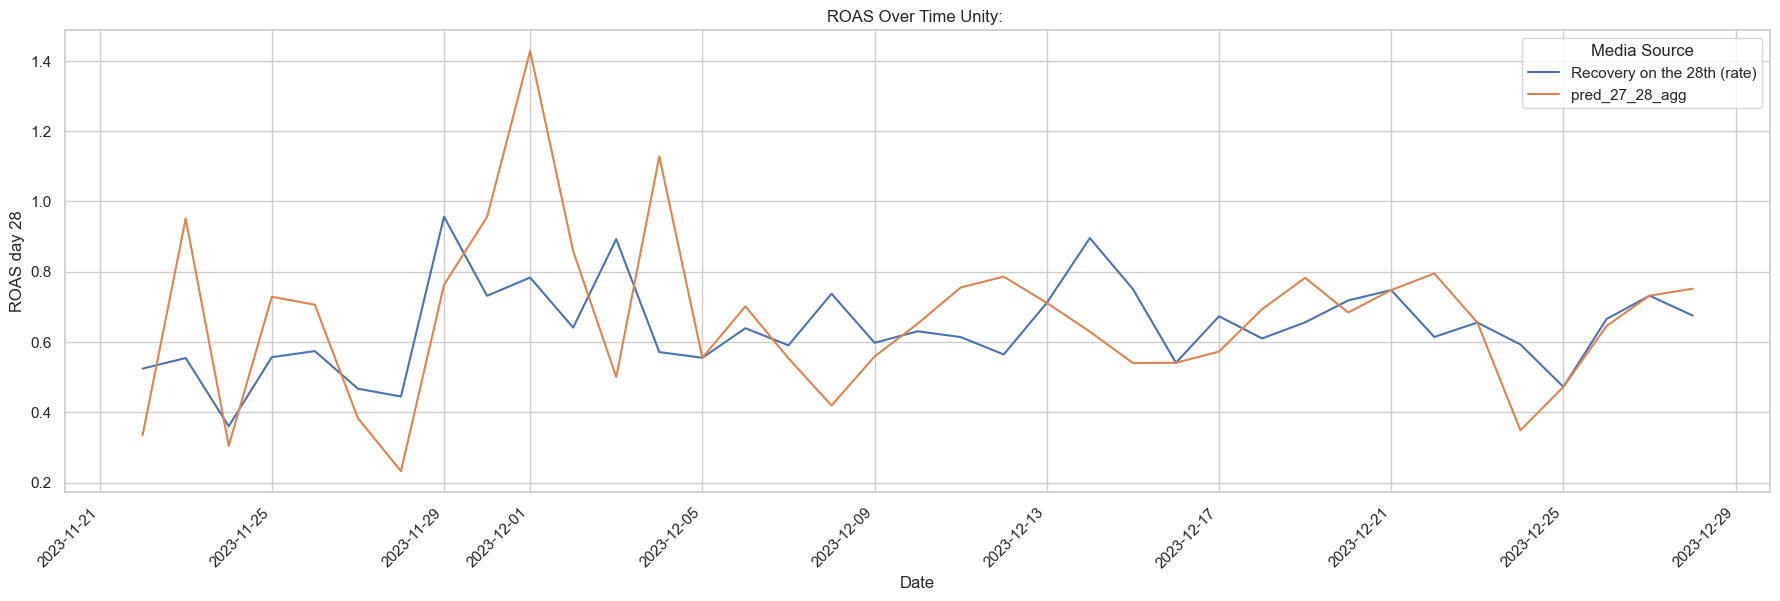

In [127]:
### Check the Joint results

filtered_df = dev_df_check.copy()
# filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df = filtered_df.sort_values(by = 'date')
filtered_df['actual_28'] = filtered_df['actual_28']/filtered_df['cost']

# Melt the DataFrame to long format for easier plotting
df_long = pd.melt(filtered_df, id_vars=['date'], value_vars=['Recovery on the 28th (rate)',  'pred_27_28_agg'])
# df_long['date'] = pd.to_datetime(df_long['date']).dt.date.apply(lambda x: int(x.strftime('%Y%m%d')))
df_long['date'] = pd.to_datetime(df_long['date'], format='%Y%m%d')

# Create the lineplot
plt.figure(figsize=(22, 6))
sns.lineplot(x='date', y='value', hue='variable', markers=True, data=df_long)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('ROAS day 28')
plt.title(f'ROAS Over Time Unity: ')

# Display the legend
plt.legend(title='Media Source')

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [128]:
# Remove the last data points and remove the pred_ columns. This is too much
with open('acorn_games_ios_ptlv_dictionary_2024.pkl', 'wb') as file:
    pickle.dump(rules_dict, file)